# U-NET FOR PARAMOS IN THE WORLD

In this notebook we will use the U-Net architecture to segment the paramos in the world. 

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Cuda info 

In [3]:
!nvidia-smi

Wed Mar 27 11:11:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.103                Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti     On  | 00000000:01:00.0  On |                  N/A |
|  0%   37C    P8              11W / 285W |   6842MiB / 12282MiB |     23%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import sagemaker
import os
import boto3
import sys
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
print("Region = {}".format(region))


In [ ]:
s3 = boto3.resource('s3')

bucket_name = 'bucket-name'

def download_s3_folders(bucket_name, prefixes):
    bucket = s3.Bucket(bucket_name)
    for prefix in prefixes:
        for obj in bucket.objects.filter(Prefix=prefix):
            destination_path = os.path.join('..', obj.key)
            if not os.path.exists(os.path.dirname(destination_path)):
                os.makedirs(os.path.dirname(destination_path))
            bucket.download_file(obj.key, destination_path)

download_s3_folders(bucket_name, ['config/', 'data/', 'packages/'])

In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import packages.utils.get_path as path
import config.constants as const
ABSOLUTE_PATH = path.make_path()

In [5]:
data_train_path = path.make_path(ABSOLUTE_PATH, const.DATA_DIR, const.PROCESSED_DIR, const.TRAIN_DIR)
data_val_path = path.make_path(ABSOLUTE_PATH, const.DATA_DIR, const.PROCESSED_DIR, const.VALIDATION_DIR)
data_eval_path = path.make_path(ABSOLUTE_PATH, const.DATA_DIR, const.PROCESSED_DIR, const.EVALUATION_DIR)
normalized_path = path.make_path(ABSOLUTE_PATH, const.DATA_DIR, const.PROCESSED_DIR, const.NORMALIZATION_DIR)

In [6]:
import numpy as np

train_rgb_images = np.load("{}/{}".format(data_train_path, const.TRAIN_RGB_NPY))
train_label_images = np.load("{}/{}".format(data_train_path, const.TRAIN_LABEL_NPY))

eval_rgb_images = np.load("{}/{}".format(data_val_path, const.VAL_RGB_NPY))
eval_label_images = np.load("{}/{}".format(data_val_path, const.VAL_LABEL_NPY))

val_rgb_images = np.load("{}/{}".format(data_eval_path, const.EVAL_RGB_NPY))
val_label_images = np.load("{}/{}".format(data_eval_path, const.EVAL_LABEL_NPY))


In [7]:

#Z-score normalization
mean = np.load("{}/{}".format(normalized_path, const.MEAN_NPY))
std = np.load("{}/{}".format(normalized_path, const.STD_NPY))

train_rgb_images = (train_rgb_images - mean) / std
eval_rgb_images = (eval_rgb_images - mean) / std
val_rgb_images = (val_rgb_images - mean) / std



In [8]:
# Normalize the masks using the same normalization as the images
train_label_images = train_label_images / 255.0
eval_label_images = eval_label_images / 255.0
val_label_images = val_label_images / 255.0


In [9]:
# Convert labels to binary masks
train_label_images = np.mean(train_label_images, axis=-1, keepdims=True)
val_label_images = np.mean(val_label_images, axis=-1, keepdims=True)
eval_label_images = np.mean(eval_label_images, axis=-1, keepdims=True)

In [10]:

# Ensure that the masks are binary (0 or 1)
train_label_images = (train_label_images > 0.5).astype(np.float32)
val_label_images = (val_label_images > 0.5).astype(np.float32)
eval_label_images = (eval_label_images > 0.5).astype(np.float32)

# UNET Model

In [11]:
import tensorflow as tf


def conv_block(inputs, filters, kernel_size=3, activation='relu', dropout_rate=0.0):
    x = tf.keras.layers.Conv2D(filters, kernel_size, activation=activation, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, activation=activation, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

def upconv_block(inputs, skip_inputs, filters, kernel_size=3, activation='relu', dropout_rate=0.0):
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=2, padding='same')(inputs)
    x = tf.keras.layers.concatenate([x, skip_inputs])
    x = conv_block(x, filters, kernel_size, activation, dropout_rate)
    return x

def unet(input_shape=(256, 256, 3), num_classes=1, init_filters=64, dropout_rate=0.0):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Capas de contracción
    c1 = conv_block(inputs, init_filters, dropout_rate=dropout_rate)
    p1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c1)
    c2 = conv_block(p1, init_filters * 2, dropout_rate=dropout_rate)
    p2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c2)
    c3 = conv_block(p2, init_filters * 4, dropout_rate=dropout_rate)
    p3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c3)
    c4 = conv_block(p3, init_filters * 8, dropout_rate=dropout_rate)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
    c5 = conv_block(p4, init_filters * 16, dropout_rate=dropout_rate)

    # Capas de expansión
    u1 = upconv_block(c5, c4, init_filters * 8, dropout_rate=dropout_rate)
    u2 = upconv_block(u1, c3, init_filters * 4, dropout_rate=dropout_rate)
    u3 = upconv_block(u2, c2, init_filters * 2, dropout_rate=dropout_rate)
    u4 = upconv_block(u3, c1, init_filters, dropout_rate=dropout_rate)

    # Capa de salida
    outputs = tf.keras.layers.Conv2D(num_classes, 1, activation='sigmoid')(u4)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

2024-03-27 11:11:47.496610: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-27 11:11:47.633989: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 11:11:47.634073: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 11:11:47.634250: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-27 11:11:47.706310: I tensorflow/core/platform/cpu_feature_g

In [12]:
model = unet(input_shape=(256, 256, 3), num_classes=1, init_filters=64, dropout_rate=0.0)

2024-03-27 11:11:50.622958: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-27 11:11:50.664287: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-27 11:11:50.664669: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-27 11:11:50.669376: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-27 11:11:50.669763: I tensorflow/compile

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['batch_normalization[0][0

                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 256)          0         ['dropout_2[0][0]']           
 g2D)                                                                                             
                                                                                                  
 conv2d_6 (Conv2D)           (None, 32, 32, 512)          1180160   ['max_pooling2d_2[0][0]']     
                                                                                                  
 batch_normalization_6 (Bat  (None, 32, 32, 512)          2048      ['conv2d_6[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 conv2d_7 (Conv2D)           (None, 32, 32, 512)          2359808   ['batch_normalization_6[0][0]'
          

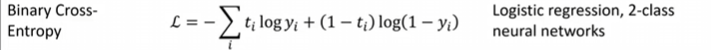

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint =path.make_path(ABSOLUTE_PATH, const.REPORT_DIR)

cp_callback = ModelCheckpoint(filepath="{}/{}".format(checkpoint, const.FILE_CKPT),
                              save_weights_only=False,
                              verbose=3)

In [16]:
history = model.fit(train_rgb_images, train_label_images, epochs=28, batch_size=16, validation_data=(val_rgb_images, val_label_images), callbacks=[cp_callback])

Epoch 1/28


2024-03-27 11:12:05.923180: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-03-27 11:12:07.286735: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-27 11:12:07.288296: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-03-27 11:12:07.288321: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2024-03-27 11:12:07.288433: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-03-27 

  1/156 [..............................] - ETA: 11:30:55 - loss: 0.9381 - accuracy: 0.5146

2024-03-27 11:16:29.460456: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



156/156 [==============================] - ETA: 0s - loss: 0.5524 - accuracy: 0.7336
Epoch 1: saving model to /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt
INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


156/156 [==============================] - 396s 826ms/step - loss: 0.5524 - accuracy: 0.7336 - val_loss: 0.7295 - val_accuracy: 0.5399
Epoch 2/28


2024-03-27 11:18:37.583711: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 512.14MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-27 11:18:37.584102: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.69GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


  1/156 [..............................] - ETA: 2:12 - loss: 0.4175 - accuracy: 0.8149

2024-03-27 11:18:38.436381: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 512.14MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-27 11:18:38.436772: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.69GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


  2/156 [..............................] - ETA: 1:45 - loss: 0.4311 - accuracy: 0.8088

2024-03-27 11:18:39.117835: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 512.14MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


156/156 [==============================] - ETA: 0s - loss: 0.4042 - accuracy: 0.8274
Epoch 2: saving model to /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt
INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


156/156 [==============================] - 124s 794ms/step - loss: 0.4042 - accuracy: 0.8274 - val_loss: 0.5546 - val_accuracy: 0.7360
Epoch 3/28
156/156 [==============================] - ETA: 0s - loss: 0.3698 - accuracy: 0.8451
Epoch 3: saving model to /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt
INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


156/156 [==============================] - 123s 791ms/step - loss: 0.3698 - accuracy: 0.8451 - val_loss: 0.3740 - val_accuracy: 0.8408
Epoch 4/28
156/156 [==============================] - ETA: 0s - loss: 0.3484 - accuracy: 0.8551
Epoch 4: saving model to /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt
INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


156/156 [==============================] - 123s 788ms/step - loss: 0.3484 - accuracy: 0.8551 - val_loss: 0.3265 - val_accuracy: 0.8650
Epoch 5/28
156/156 [==============================] - ETA: 0s - loss: 0.3308 - accuracy: 0.8629
Epoch 5: saving model to /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt
INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


156/156 [==============================] - 123s 788ms/step - loss: 0.3308 - accuracy: 0.8629 - val_loss: 0.3073 - val_accuracy: 0.8746
Epoch 6/28
156/156 [==============================] - ETA: 0s - loss: 0.3283 - accuracy: 0.8642
Epoch 6: saving model to /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt
INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


156/156 [==============================] - 123s 788ms/step - loss: 0.3283 - accuracy: 0.8642 - val_loss: 0.3132 - val_accuracy: 0.8700
Epoch 7/28
156/156 [==============================] - ETA: 0s - loss: 0.3107 - accuracy: 0.8711
Epoch 7: saving model to /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt
INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


156/156 [==============================] - 124s 792ms/step - loss: 0.3107 - accuracy: 0.8711 - val_loss: 0.2998 - val_accuracy: 0.8753
Epoch 8/28
156/156 [==============================] - ETA: 0s - loss: 0.3078 - accuracy: 0.8734
Epoch 8: saving model to /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt
INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


156/156 [==============================] - 123s 786ms/step - loss: 0.3078 - accuracy: 0.8734 - val_loss: 0.2935 - val_accuracy: 0.8797
Epoch 9/28
156/156 [==============================] - ETA: 0s - loss: 0.3130 - accuracy: 0.8713
Epoch 9: saving model to /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt
INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


156/156 [==============================] - 123s 788ms/step - loss: 0.3130 - accuracy: 0.8713 - val_loss: 0.2931 - val_accuracy: 0.8821
Epoch 10/28
156/156 [==============================] - ETA: 0s - loss: 0.2933 - accuracy: 0.8794
Epoch 10: saving model to /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt
INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


156/156 [==============================] - 123s 790ms/step - loss: 0.2933 - accuracy: 0.8794 - val_loss: 0.2922 - val_accuracy: 0.8823
Epoch 11/28
156/156 [==============================] - ETA: 0s - loss: 0.2929 - accuracy: 0.8797
Epoch 11: saving model to /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt
INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


156/156 [==============================] - 123s 790ms/step - loss: 0.2929 - accuracy: 0.8797 - val_loss: 0.2809 - val_accuracy: 0.8835
Epoch 12/28
156/156 [==============================] - ETA: 0s - loss: 0.2793 - accuracy: 0.8860
Epoch 12: saving model to /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt
INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


156/156 [==============================] - 125s 802ms/step - loss: 0.2793 - accuracy: 0.8860 - val_loss: 0.2860 - val_accuracy: 0.8829
Epoch 13/28
156/156 [==============================] - ETA: 0s - loss: 0.2796 - accuracy: 0.8856
Epoch 13: saving model to /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt
INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


156/156 [==============================] - 109s 699ms/step - loss: 0.2796 - accuracy: 0.8856 - val_loss: 0.2676 - val_accuracy: 0.8909
Epoch 14/28
156/156 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.8891
Epoch 14: saving model to /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt
INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


156/156 [==============================] - 99s 631ms/step - loss: 0.2736 - accuracy: 0.8891 - val_loss: 0.2699 - val_accuracy: 0.8889
Epoch 15/28
156/156 [==============================] - ETA: 0s - loss: 0.2681 - accuracy: 0.8905
Epoch 15: saving model to /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt
INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


156/156 [==============================] - 102s 656ms/step - loss: 0.2681 - accuracy: 0.8905 - val_loss: 0.2801 - val_accuracy: 0.8879
Epoch 16/28
156/156 [==============================] - ETA: 0s - loss: 0.2621 - accuracy: 0.8939
Epoch 16: saving model to /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt
INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


156/156 [==============================] - 101s 649ms/step - loss: 0.2621 - accuracy: 0.8939 - val_loss: 0.2663 - val_accuracy: 0.8911
Epoch 17/28
156/156 [==============================] - ETA: 0s - loss: 0.2691 - accuracy: 0.8918
Epoch 17: saving model to /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt
INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


156/156 [==============================] - 98s 630ms/step - loss: 0.2691 - accuracy: 0.8918 - val_loss: 0.2623 - val_accuracy: 0.8917
Epoch 18/28
156/156 [==============================] - ETA: 0s - loss: 0.2555 - accuracy: 0.8973
Epoch 18: saving model to /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt
INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


156/156 [==============================] - 98s 628ms/step - loss: 0.2555 - accuracy: 0.8973 - val_loss: 0.2525 - val_accuracy: 0.8962
Epoch 19/28
156/156 [==============================] - ETA: 0s - loss: 0.2537 - accuracy: 0.8975
Epoch 19: saving model to /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt
INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


156/156 [==============================] - 98s 629ms/step - loss: 0.2537 - accuracy: 0.8975 - val_loss: 0.2648 - val_accuracy: 0.8906
Epoch 20/28
156/156 [==============================] - ETA: 0s - loss: 0.2477 - accuracy: 0.9016
Epoch 20: saving model to /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt
INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


156/156 [==============================] - 98s 629ms/step - loss: 0.2477 - accuracy: 0.9016 - val_loss: 0.2638 - val_accuracy: 0.8919
Epoch 21/28
156/156 [==============================] - ETA: 0s - loss: 0.2507 - accuracy: 0.9002
Epoch 21: saving model to /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt
INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


156/156 [==============================] - 98s 625ms/step - loss: 0.2507 - accuracy: 0.9002 - val_loss: 0.2608 - val_accuracy: 0.8928
Epoch 22/28
156/156 [==============================] - ETA: 0s - loss: 0.2323 - accuracy: 0.9073
Epoch 22: saving model to /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt
INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


156/156 [==============================] - 98s 626ms/step - loss: 0.2323 - accuracy: 0.9073 - val_loss: 0.2540 - val_accuracy: 0.8955
Epoch 23/28
156/156 [==============================] - ETA: 0s - loss: 0.2327 - accuracy: 0.9068
Epoch 23: saving model to /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt
INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


156/156 [==============================] - 98s 626ms/step - loss: 0.2327 - accuracy: 0.9068 - val_loss: 0.2610 - val_accuracy: 0.8922
Epoch 24/28
156/156 [==============================] - ETA: 0s - loss: 0.2279 - accuracy: 0.9093
Epoch 24: saving model to /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt
INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


156/156 [==============================] - 98s 629ms/step - loss: 0.2279 - accuracy: 0.9093 - val_loss: 0.2612 - val_accuracy: 0.8919
Epoch 25/28
156/156 [==============================] - ETA: 0s - loss: 0.2248 - accuracy: 0.9103
Epoch 25: saving model to /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt
INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


156/156 [==============================] - 99s 637ms/step - loss: 0.2248 - accuracy: 0.9103 - val_loss: 0.2588 - val_accuracy: 0.8958
Epoch 26/28
156/156 [==============================] - ETA: 0s - loss: 0.2129 - accuracy: 0.9153
Epoch 26: saving model to /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt
INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


156/156 [==============================] - 98s 629ms/step - loss: 0.2129 - accuracy: 0.9153 - val_loss: 0.2456 - val_accuracy: 0.8992
Epoch 27/28
156/156 [==============================] - ETA: 0s - loss: 0.2225 - accuracy: 0.9115
Epoch 27: saving model to /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt
INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


156/156 [==============================] - 98s 627ms/step - loss: 0.2225 - accuracy: 0.9115 - val_loss: 0.2647 - val_accuracy: 0.8958
Epoch 28/28
156/156 [==============================] - ETA: 0s - loss: 0.2082 - accuracy: 0.9180
Epoch 28: saving model to /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt
INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


INFO:tensorflow:Assets written to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../reports/CP3.ckpt/assets


156/156 [==============================] - 98s 629ms/step - loss: 0.2082 - accuracy: 0.9180 - val_loss: 0.2665 - val_accuracy: 0.8974


In [17]:
import matplotlib.pyplot as plt
def plot_history(history):
    # Graficar accuracy y loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Gráfica de accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Gráfica de loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

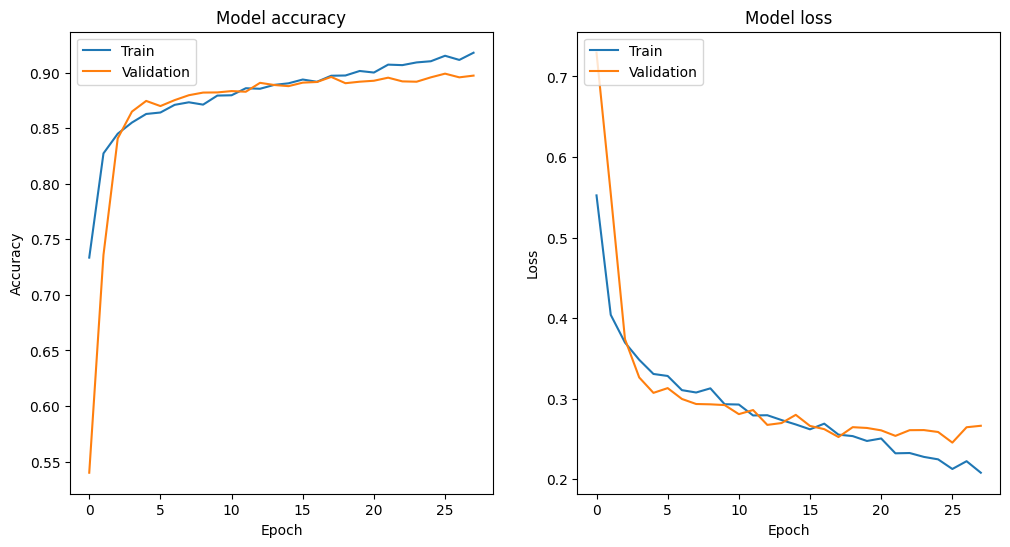

In [18]:
import matplotlib.pyplot as plt
plot_history(history)

In [19]:
loss, accuracy = model.evaluate(eval_rgb_images, eval_label_images)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

 1/26 [>.............................] - ETA: 1:09 - loss: 0.3080 - accuracy: 0.8925

2024-03-27 12:07:50.320705: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-27 12:07:50.324278: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


26/26 [==============================] - 9s 256ms/step - loss: 0.2548 - accuracy: 0.9013
Loss: 0.25484907627105713
Accuracy: 0.9012706279754639


In [20]:
#save the model 

model.save(ABSOLUTE_PATH + f"/models/4.28032024-UNET.h5")

/root/anaconda3/envs/preprocessing/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
# use the model to predict on the test set 

predictions = model.predict(eval_rgb_images)


26/26 [==============================] - 7s 258ms/step


In [22]:
from sklearn.metrics import classification_report
import numpy as np

# Flatten the arrays for sklearn
true_labels = eval_label_images.flatten()
predicted_labels = np.round(predictions).flatten()  # round predictions to 0 or 1

print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

         0.0       0.89      0.92      0.91  28216331
         1.0       0.91      0.88      0.90  26309621

    accuracy                           0.90  54525952
   macro avg       0.90      0.90      0.90  54525952
weighted avg       0.90      0.90      0.90  54525952



664


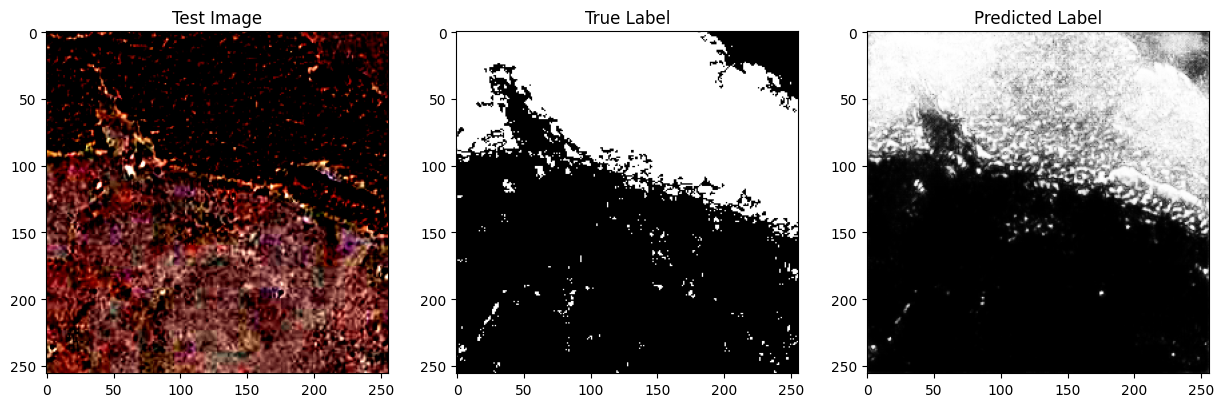

In [56]:
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import random
# random numer in eval_label_images  length
index = random.randint(0, len(eval_label_images) - 1) #43 ,482, 596
print(index)
test_image = eval_rgb_images[index]
true_label = eval_label_images[index]
predicted_label = predictions[index]

# Plot the test image and the masks
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(test_image)
axes[0].set_title('Test Image')
axes[1].imshow(true_label.squeeze(), cmap='gray')
axes[1].set_title('True Label')
axes[2].imshow(predicted_label.squeeze(), cmap='gray')
axes[2].set_title('Predicted Label')

html = """
<div style='text-align: center;'>
    <div style='display: inline-block; padding: 10px; background-color: black; color: white; border-radius: 5px; margin: 5px; font-size: 15px; font-weight: bold; box-shadow: 0px 0px 10px rgba(0, 0, 0, 0.5); font-family: Arial, sans-serif;'>Black is 'paramo'</div>
    <div style='display: inline-block; padding: 10px; background-color: white; color: black; border: 1px solid black; border-radius: 5px; margin: 5px; font-size: 15px; font-weight: bold; box-shadow: 0px 0px 10px rgba(0, 0, 0, 0.5); font-family: Arial, sans-serif;'>White is 'not paramo'</div>
</div>
"""

# Display the HTML snippet
display(HTML(html))
plt.show()